# notebook for shap analysis 
notebook: 1.2-becker-data-modeling-SHAP-analysis
author: Jonathan Becker
content: This notebook analyses the shap values for all Features of the concatenated dataset for 
            feature pruning. Feautures with modalities that have no impact on our classification should be 
            summarized in a new modality if at least some modalities show relevant impact on our model or deleted if
            all modalities show no impact on our model
goal: feature pruning



In [3]:
# imports
import pandas as pd
import numpy as np
from joblib import load, dump

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries
import sys
sys.path.append('../../library')

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
import shap

#pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# little helper functions
from cleaning_utils import distinguish_cols, print_col_categories
import time 
# google cloud storage
from google.cloud import storage
import gc_storage

/opt/homebrew/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [4]:
# loading fitted objects
bucket_name='sep25-bds-road-accidents'
key_path='../../auth/fiery-glass-478009-t8-18a81c8cbe63.json'
bucket = gc_storage.init_bucket( bucket=bucket_name,
                                 json_key_path=key_path )
gc_storage.list_bucket( bucket=bucket,
                        remote_folder='2_preprocessing' )
df = gc_storage.download( bucket=bucket,
                                  remote_path='2_preprocessing/1.2-leibold-data-preprocessing_concat.joblib')
# load fittet pipeline
preprocessing_pipeline = load("../../models//pipeline_rf_over_under_2019_2023.pkl")

# load fitted model
model = load("../../models/model_rf_over_under_2019_2023.joblib")

# Seperate features and target
X=df.drop(columns=['ind_severity'])
y=df['ind_severity']


Initialized sep25-bds-road-accidents
Number of blobs: [32]
data/processed/2_preprocessing/
data/processed/2_preprocessing/0.1-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.2-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.3-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.4-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0-becker-data-preprocessing_usagers.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_vehicles.joblib
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_test_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_train_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_test.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_train_num.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-y_test.gc
dat

In [ ]:
print(model.get_params())
df.shape
print(model.estimators_[0].tree_.n_node_samples[:10])
df.info()


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[30861 10034  9262  8157  5906  4640  4217  1741  1732   774]
<class 'pandas.core.frame.DataFrame'>
Index: 762666 entries, 0 to 807331
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 762666 non-null  int64         
 1   ind_place               762666 non-null  int64         
 2   ind_cat                 762666 non-null  int64         
 3   ind_severity            762666 non-null  int64         
 4   ind_sex                 762666 non-null  int6

In [6]:
# stratiefied subsample for shap explanation
X_sub,_,y_sub,_=train_test_split(X,y,train_size=10000,stratify=y,random_state=42)
X_sub_clean=preprocessing_pipeline.transform(X_sub)

ℹ️ AggrLocaSplit -> Aggregated from 10000 rows to 9989 groups.


In [17]:
#
print(X_sub_clean.shape)
print(X_sub_clean[:5,:])

(9989, 123)
[[ 8.66025404e-01  5.00000000e-01 -5.00000000e-01  8.66025404e-01
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+0

In [18]:
# old shaps
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sub_clean, approximate=True)

feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)

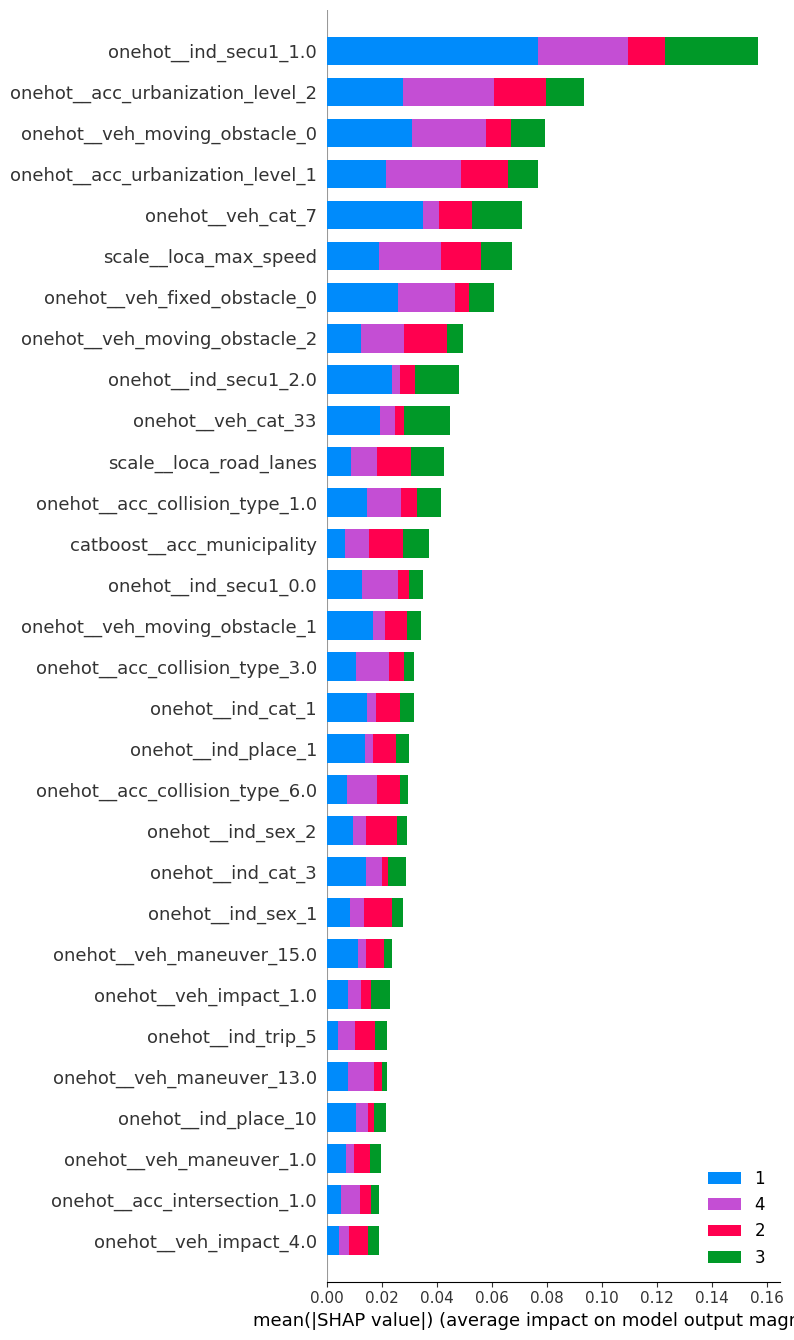

In [19]:
# Plot
shap.summary_plot(shap_values, X_sub_df, plot_type="bar", class_names=model.classes_ , title="Top 50 Features Random Forest Model", max_display=30)

In [26]:
print(X_sub_df.columns.tolist())

['cyclical__acc_hour_sin', 'cyclical__acc_hour_cos', 'cyclical__acc_month_sin', 'cyclical__acc_month_cos', 'onehot__acc_ambient_lightning_1.0', 'onehot__acc_ambient_lightning_2.0', 'onehot__acc_ambient_lightning_3.0', 'onehot__acc_ambient_lightning_4.0', 'onehot__acc_ambient_lightning_5.0', 'onehot__acc_urbanization_level_1', 'onehot__acc_urbanization_level_2', 'onehot__acc_intersection_1.0', 'onehot__acc_intersection_2.0', 'onehot__acc_intersection_3.0', 'onehot__acc_intersection_4.0', 'onehot__acc_intersection_5.0', 'onehot__acc_intersection_6.0', 'onehot__acc_intersection_7.0', 'onehot__acc_intersection_8.0', 'onehot__acc_intersection_9.0', 'onehot__acc_atmosphere_1.0', 'onehot__acc_atmosphere_2.0', 'onehot__acc_atmosphere_3.0', 'onehot__acc_atmosphere_4.0', 'onehot__acc_atmosphere_5.0', 'onehot__acc_atmosphere_6.0', 'onehot__acc_atmosphere_7.0', 'onehot__acc_atmosphere_8.0', 'onehot__acc_atmosphere_9.0', 'onehot__acc_collision_type_1.0', 'onehot__acc_collision_type_2.0', 'onehot__a

In [27]:
# new shaps
explainer = shap.Explainer(model)

# SHAP values 
shap_values=explainer(X_sub_df)

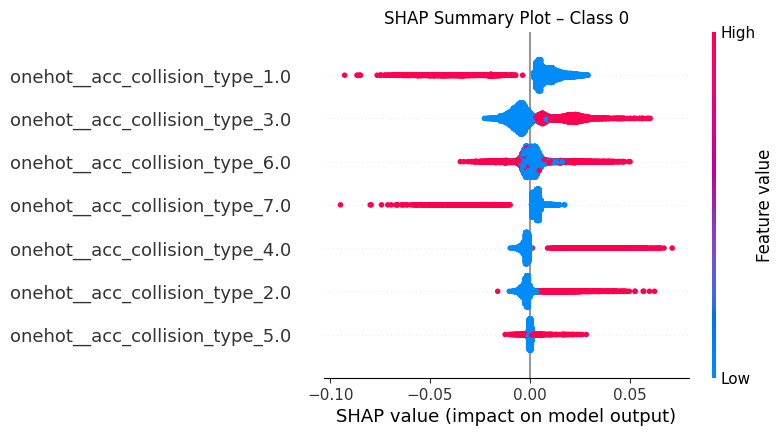

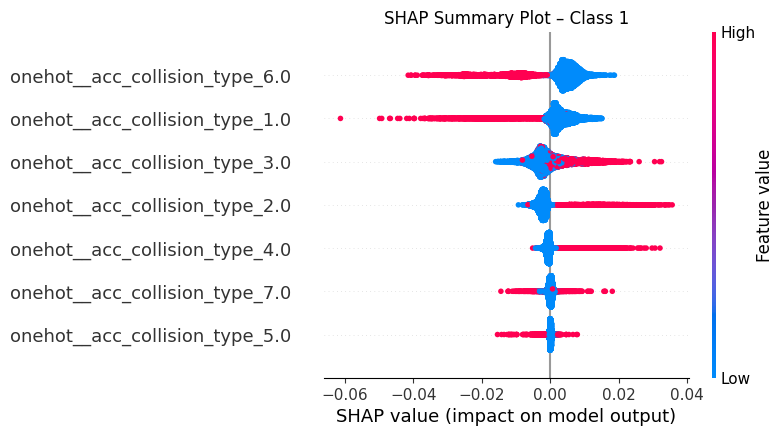

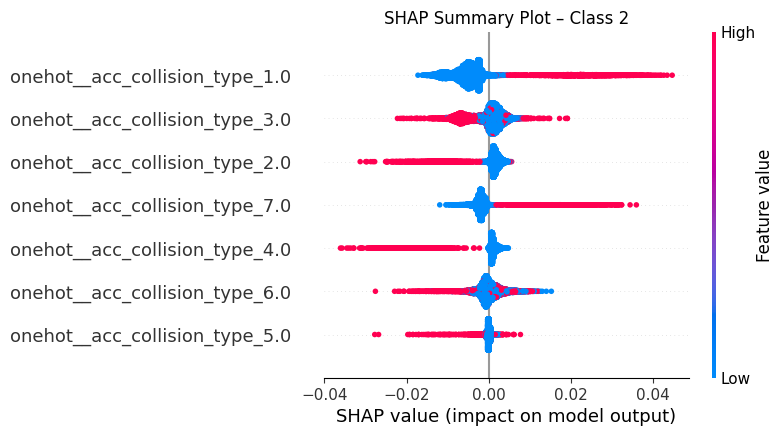

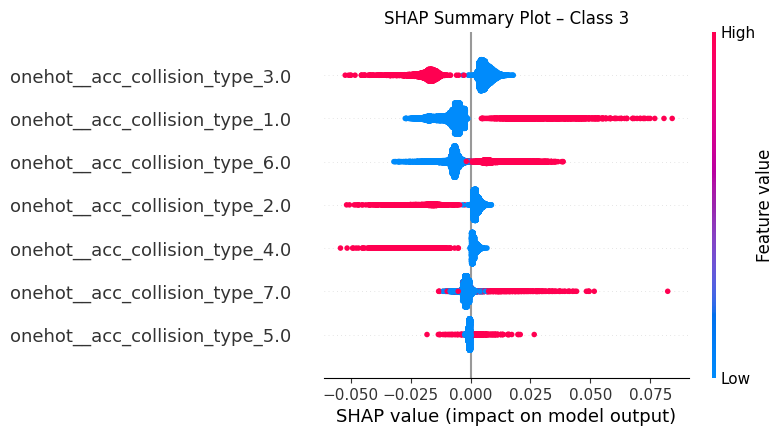

In [51]:
# Feature 1: acc_collision_type
subset_cols = [col for col in X_sub_df.columns if "acc_collision_type" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()


interpretation:
type 1.0 (frontal): shows high impact for all 4 classes. for class 2 and 3 strong positive and class 0 and 1 strong negative.
type 2.0 (from the rear): shows high impact for all 4 classes as well. but in different direction between class 0,1 and class 2,3. 
type 3.0 (by the side) shows high impact towards class 0 but moderate influence for class 1 and 3. class 2 seems to be multicolinearity. 
type 4.0 (three vehicles and more in chain): strong influence on the target classification. (class 0,1 strong positive) and class 2,3 strong negative
type 5.0 (multiple collisions): no clear strong influence for increasing, decreasing the target classes
type 6.0 (other collision): different impact between the classes. helps to separate in class 3 and 1 for example. 
type 7.0 (without collision):  also different among the target classes. 

overall we should keep all modalities, because they help to separate the 4 target classes.

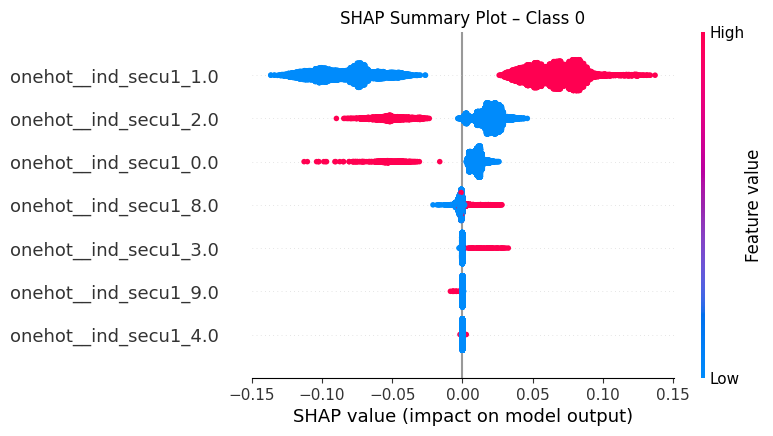

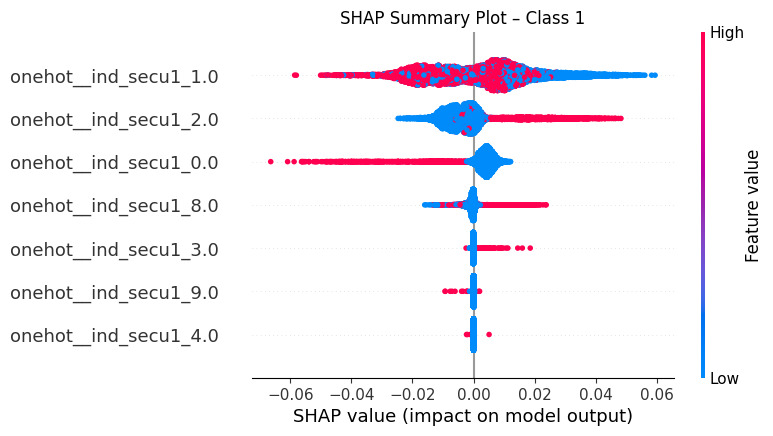

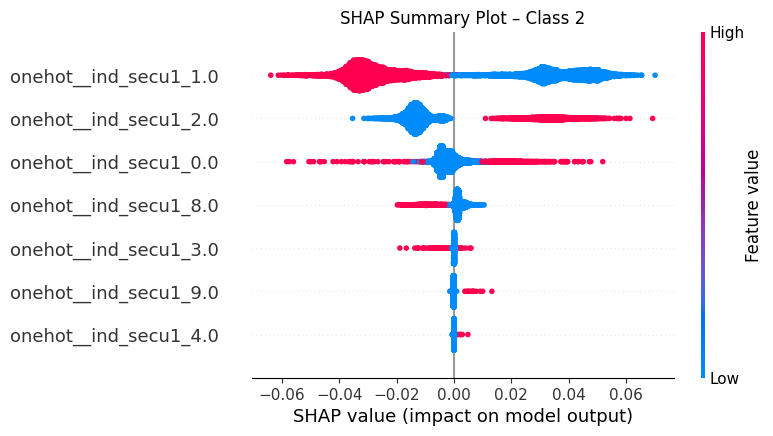

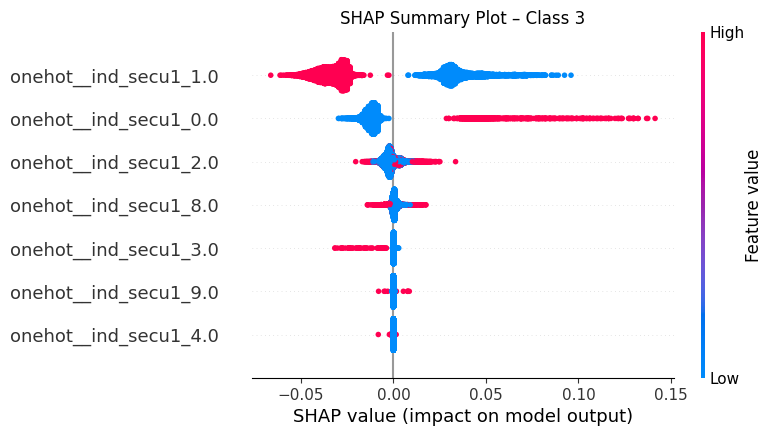

In [65]:
# feature 2: 
subset_cols = [col for col in X_sub_df.columns if "ind_secu1" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation: 
0.0, 1.0,2.0 show clear impacts towars one or more classes. 4,8,9 low or no impact. 
3.0  shows moderate impact. 
suggestion: aggregate 4,8,9 to one new modality




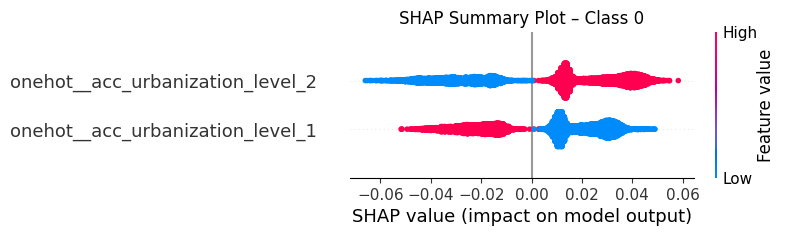

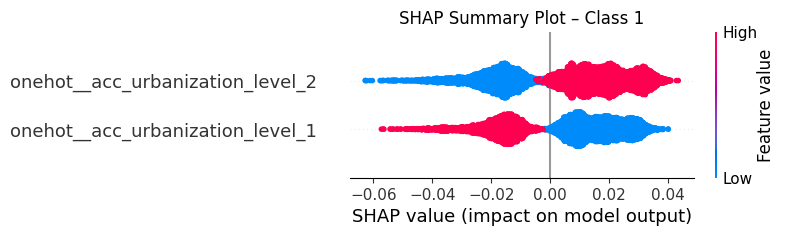

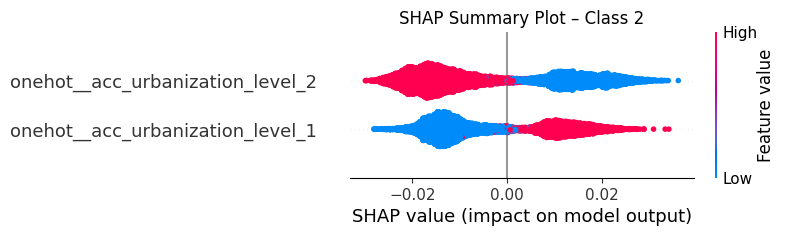

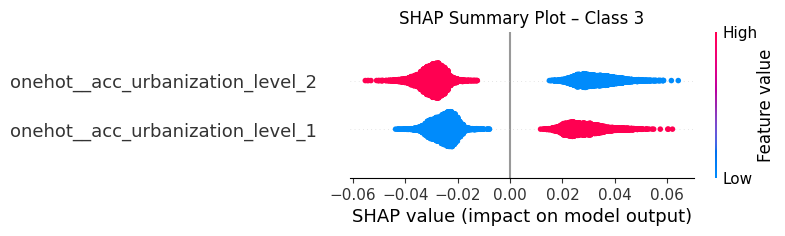

In [55]:
# feature 3: 
subset_cols = [col for col in X_sub_df.columns if "acc_urbanization_level" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation: 
both modalities help to separate the classes. we should keep both. 



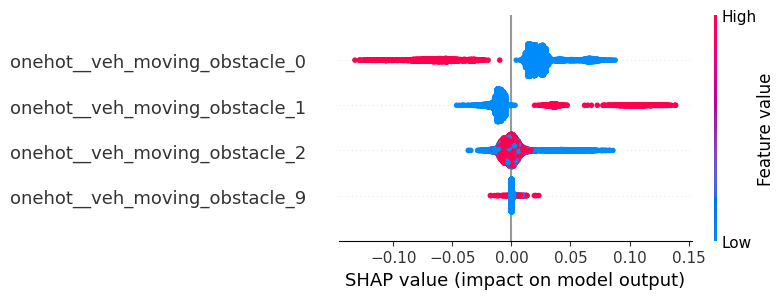

In [ ]:
# feature 4: 
subset_cols = [col for col in X_sub_df.columns if "veh_moving_obstacle" in col]
shap_class0 = shap_values.values[:, :, 0]  
shap.summary_plot(shap_class0[:, [X_sub_df.columns.get_loc(c) for c in subset_cols]],
                  X_sub_df[subset_cols],
                  feature_names=subset_cols)

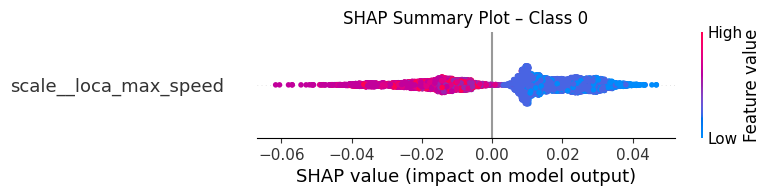

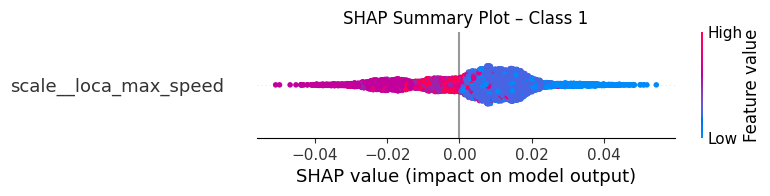

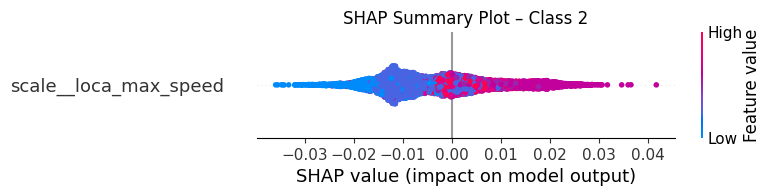

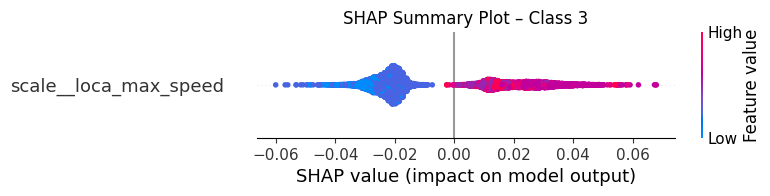

In [66]:
# feature 5:
subset_cols = [col for col in X_sub_df.columns if "loca_max_speed" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
many overlapping points but overall most of the time it seems higher max_speed increases the target class. > keep 

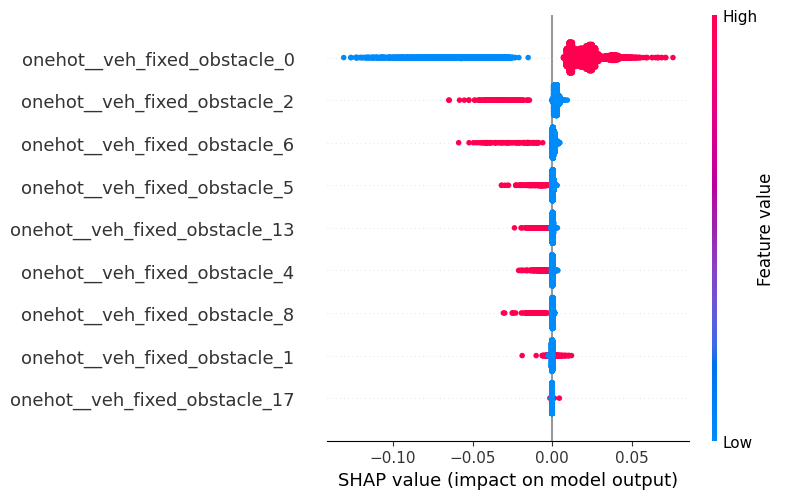

In [ ]:
# feature 6: 
subset_cols = [col for col in X_sub_df.columns if "veh_fixed_obstacle" in col]
shap_class0 = shap_values.values[:, :, 0] 
shap.summary_plot(shap_class0[:, [X_sub_df.columns.get_loc(c) for c in subset_cols]],
                  X_sub_df[subset_cols],
                  feature_names=subset_cols)

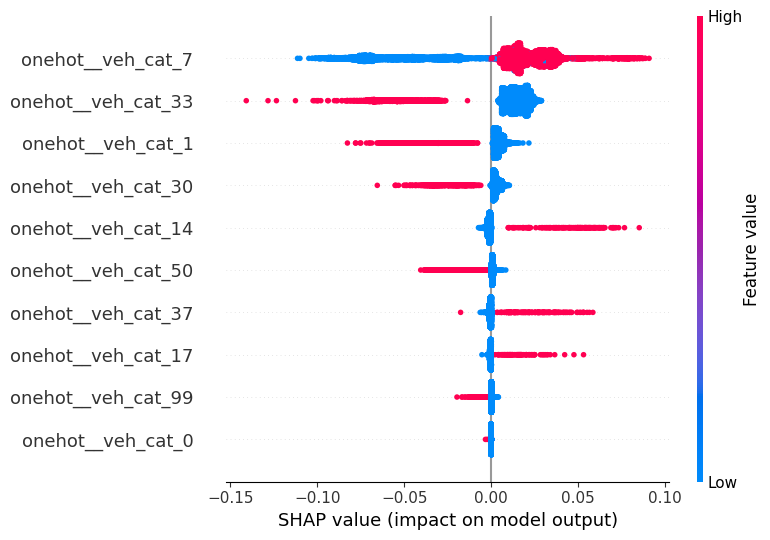

In [ ]:
# feature 7:
subset_cols = [col for col in X_sub_df.columns if "veh_cat" in col]
shap_class0 = shap_values.values[:, :, 0]  
shap.summary_plot(shap_class0[:, [X_sub_df.columns.get_loc(c) for c in subset_cols]],
                  X_sub_df[subset_cols],
                  feature_names=subset_cols)

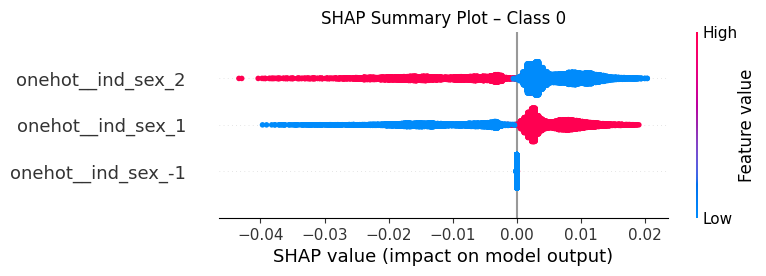

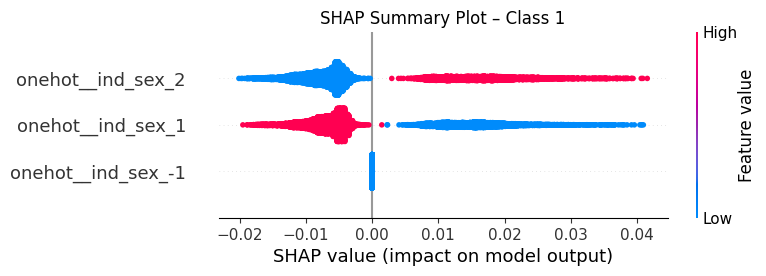

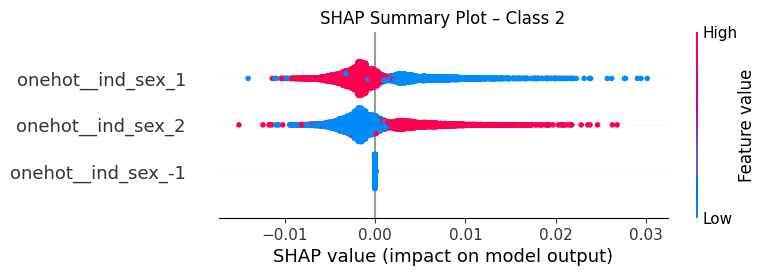

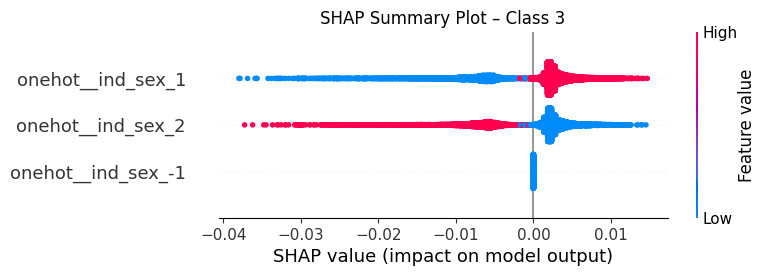

In [63]:
# feature 8: 
subset_cols = [col for col in X_sub_df.columns if "ind_sex" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation: 
ind_sex -1 has no information at all. so we could remove it without doubt. 
sex_1 and sex_2 both help to separate the classes. keep both.

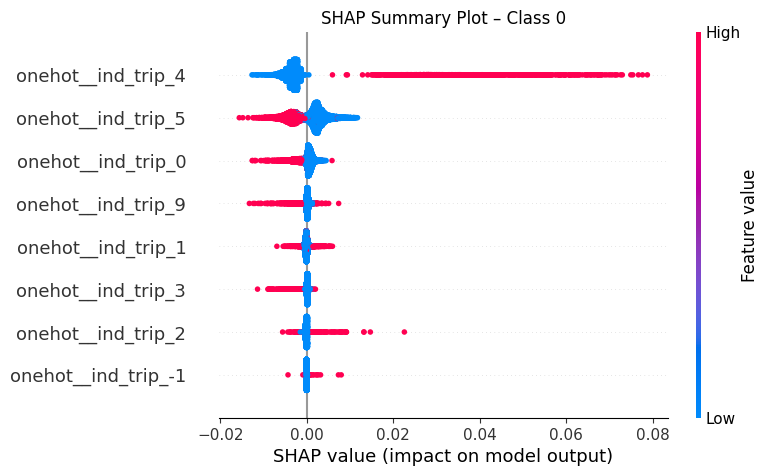

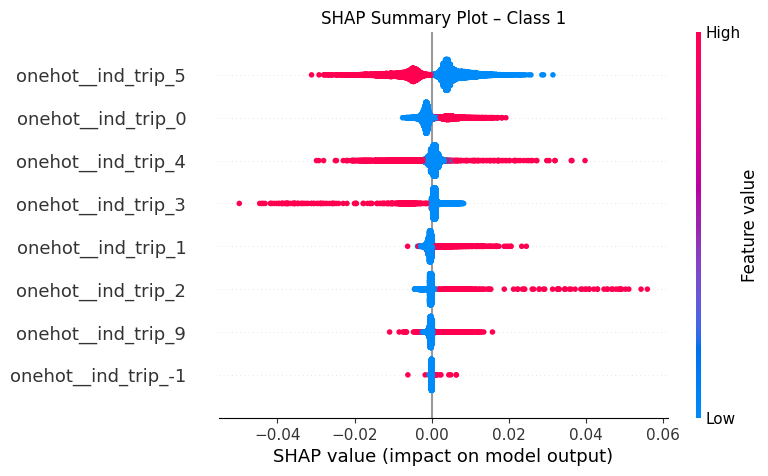

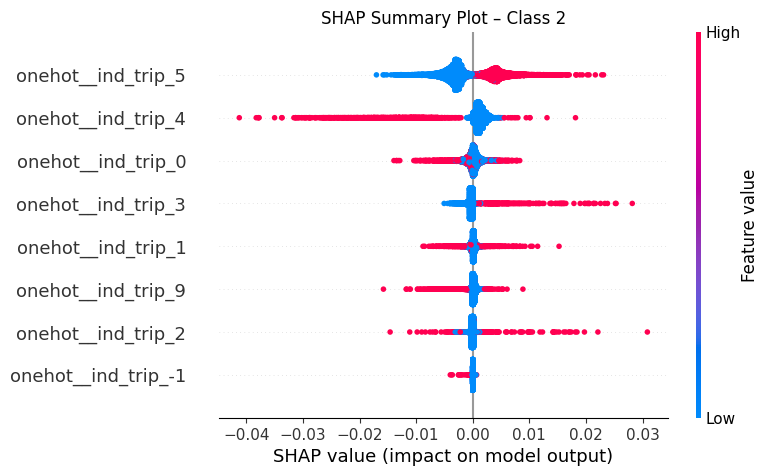

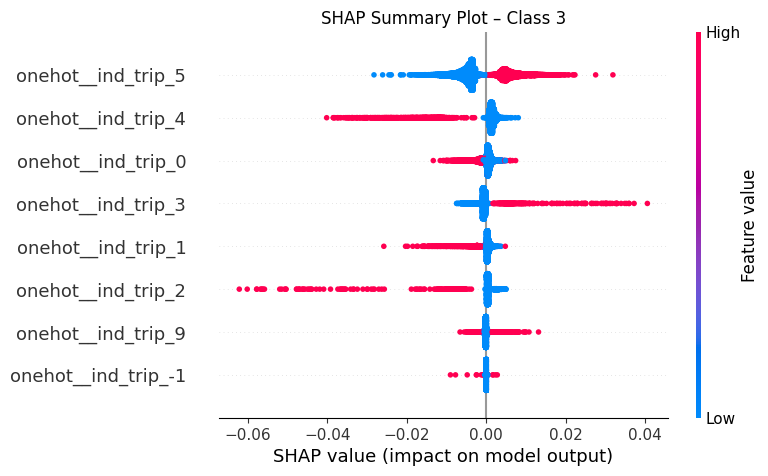

In [64]:
# feature 9: 
subset_cols = [col for col in X_sub_df.columns if "ind_trip" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
ind_trip: -1,0,1 and 9 have low shaps. aggreagation possible.
ind_trip2,3,4,5, higher shaps so we should keep them. 


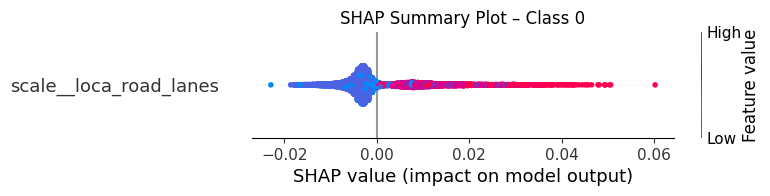

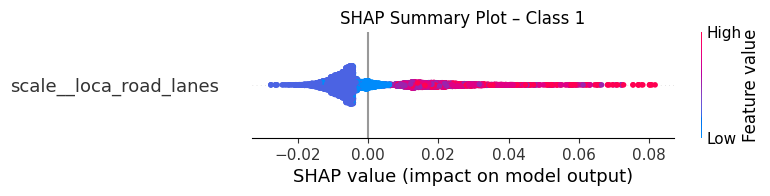

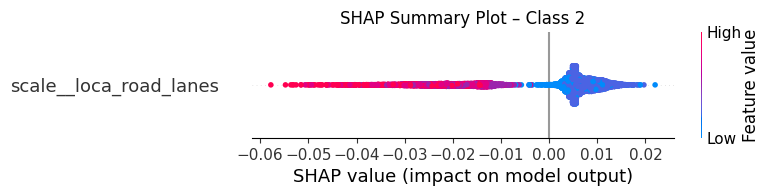

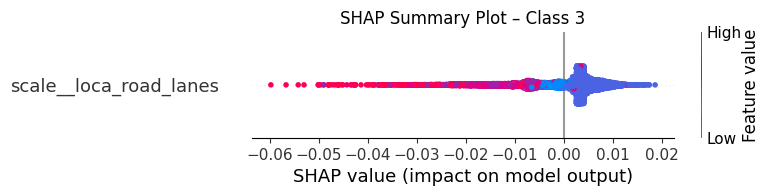

In [67]:
# feature 10:
subset_cols = [col for col in X_sub_df.columns if "loca_road_lanes" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation: 
strong shaps and clear separator for class 0,1 and 2,3

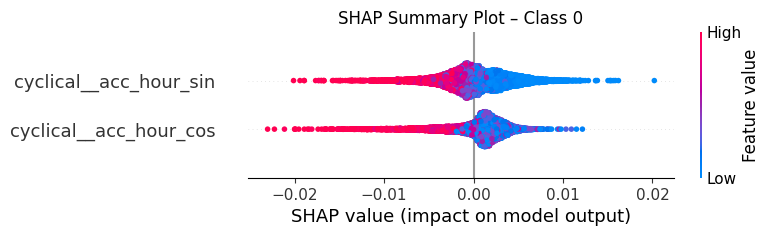

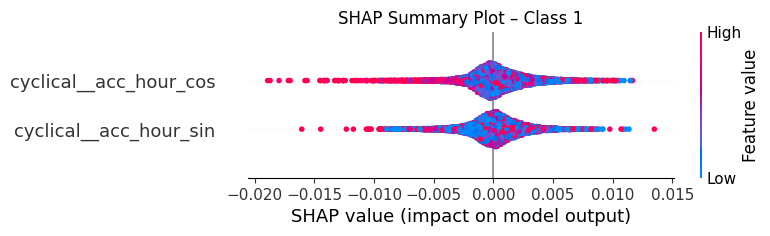

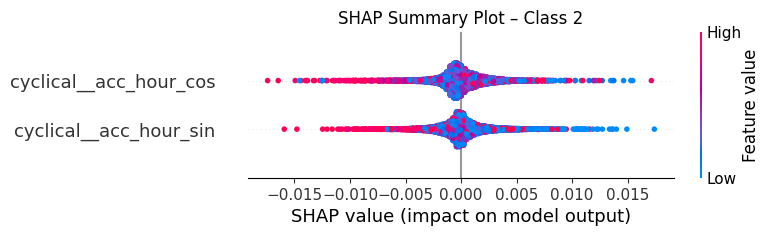

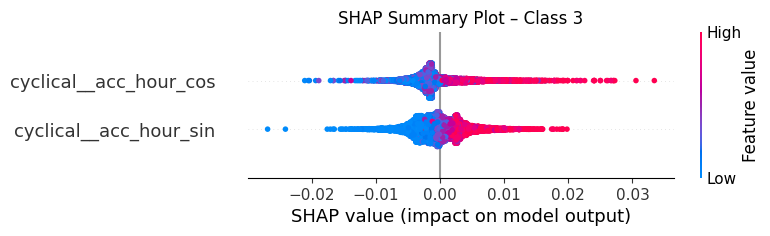

In [52]:
# feature 11:
subset_cols = [col for col in X_sub_df.columns if "acc_hour" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

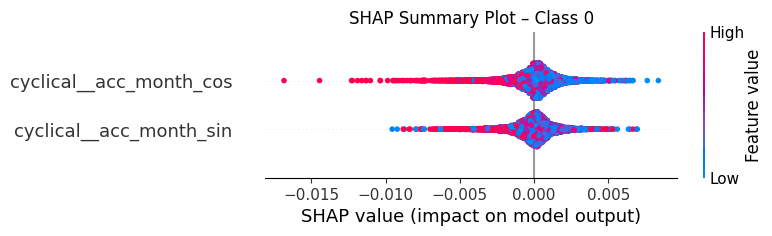

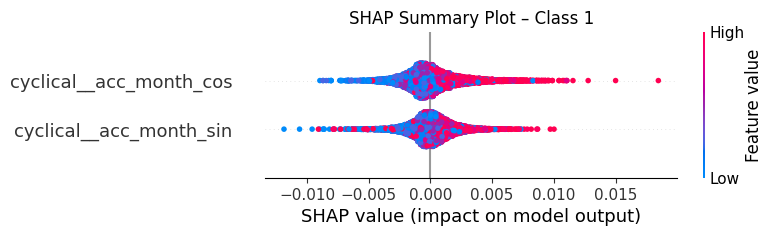

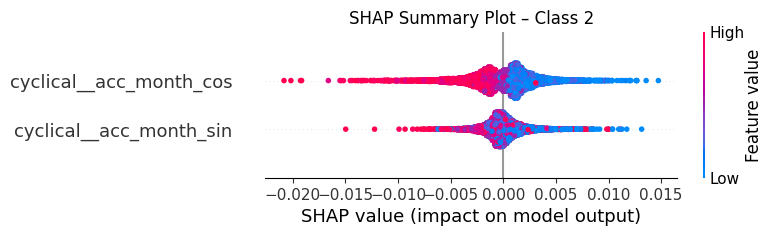

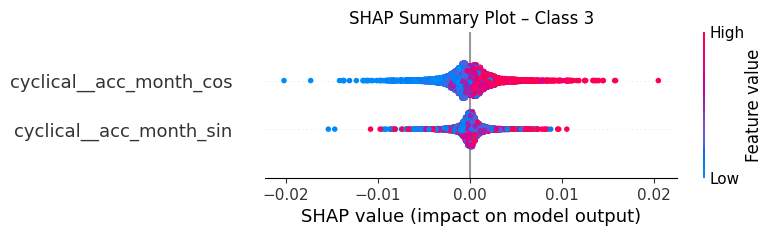

In [53]:
# feature 12:
subset_cols = [col for col in X_sub_df.columns if "acc_month" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

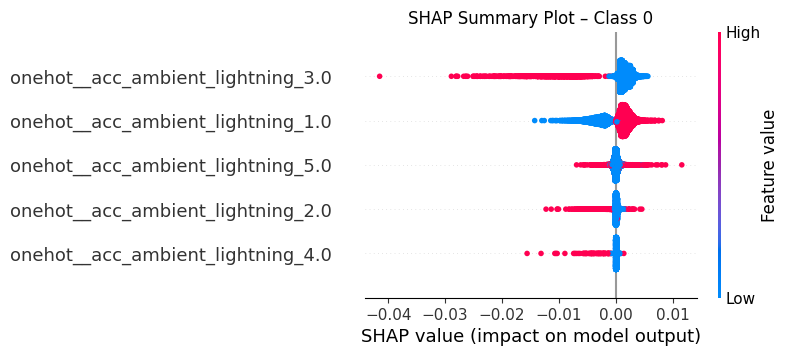

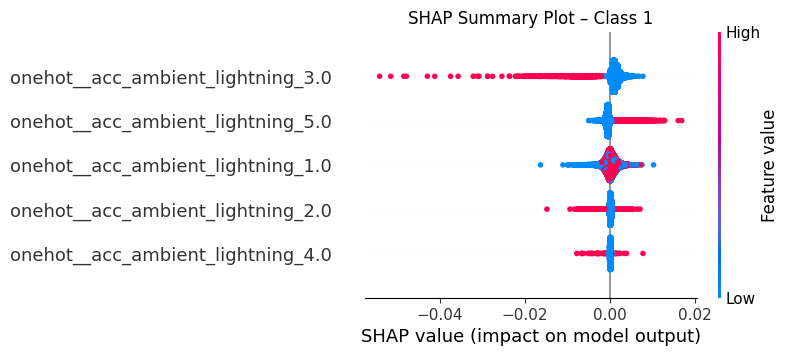

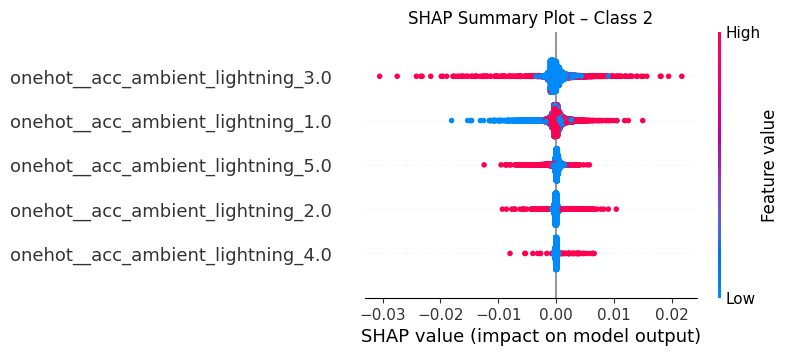

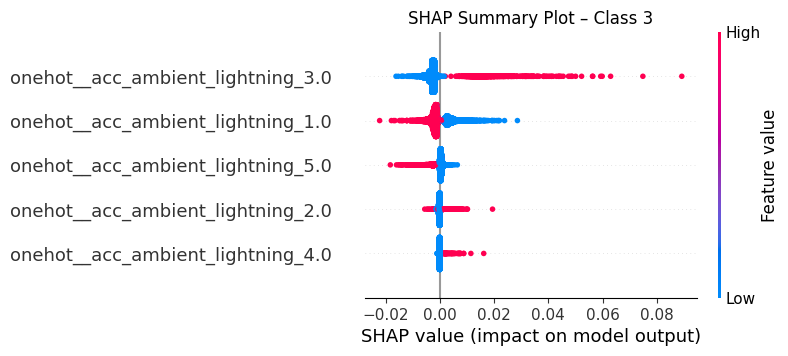

In [54]:
# feature 13:
subset_cols = [col for col in X_sub_df.columns if "acc_ambient_lightning" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
daylight shows moderate shaps. night, no street lightning also has higher shaps. 
the other modalities should be aggregated

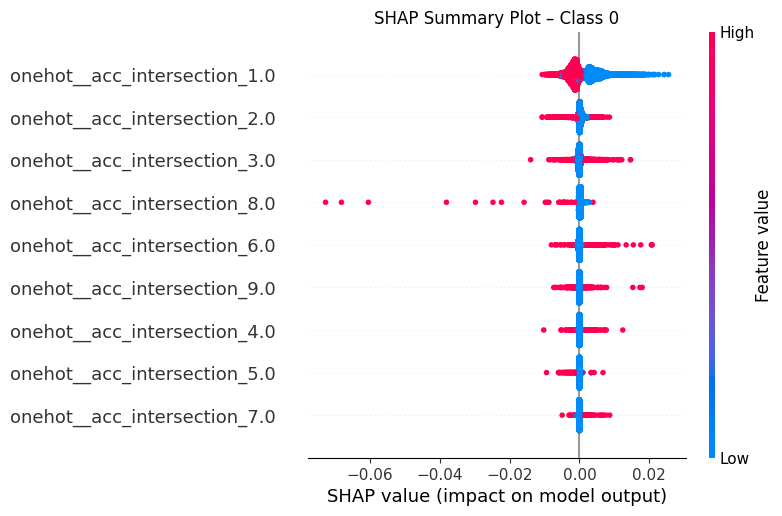

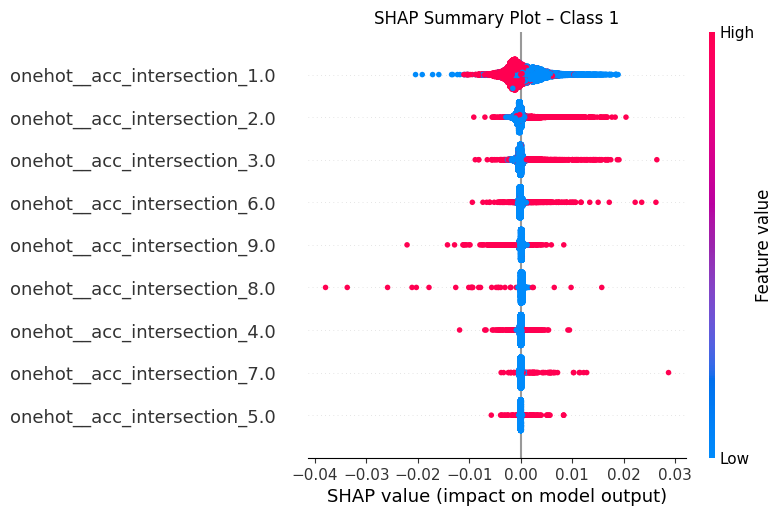

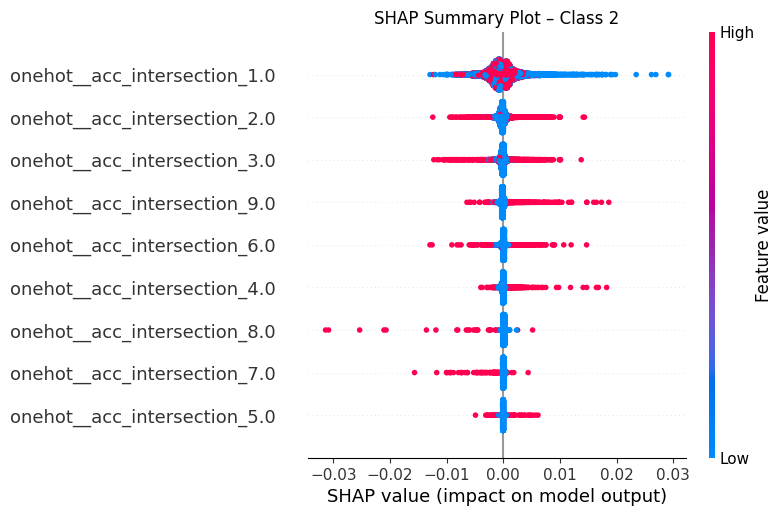

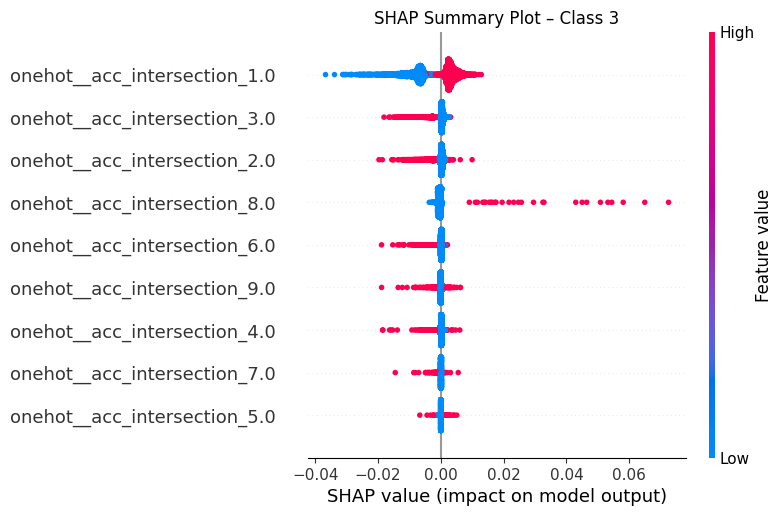

In [57]:
# feature 14:
subset_cols = [col for col in X_sub_df.columns if "acc_intersection" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
aggregation suggested for:1.0, 4.0,5.0,7.0 and 9.0
keep the other modalities. 

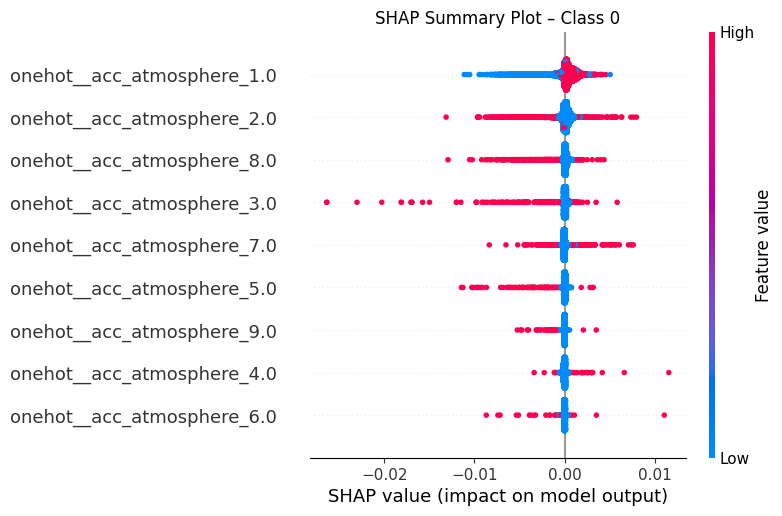

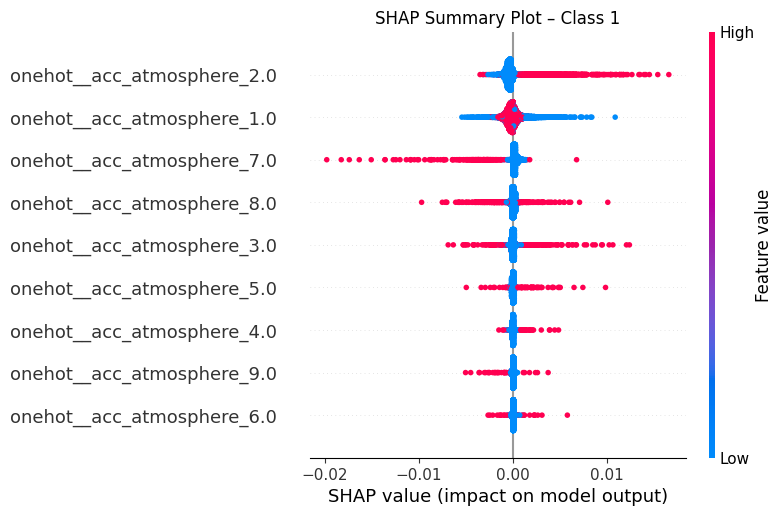

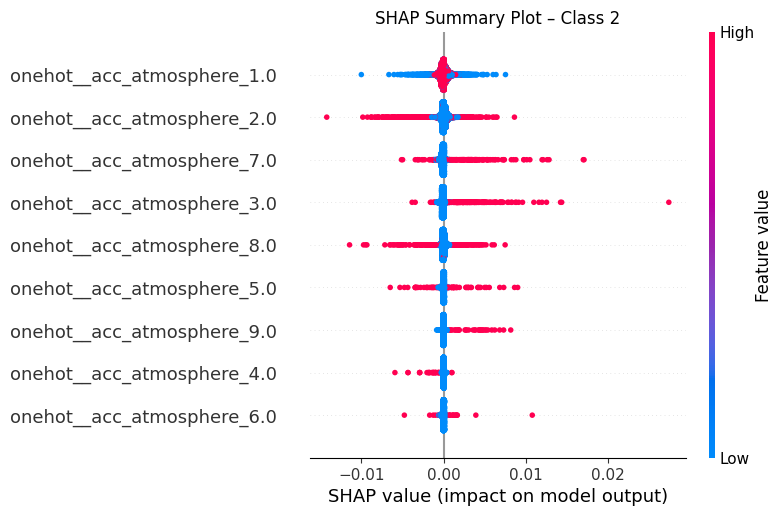

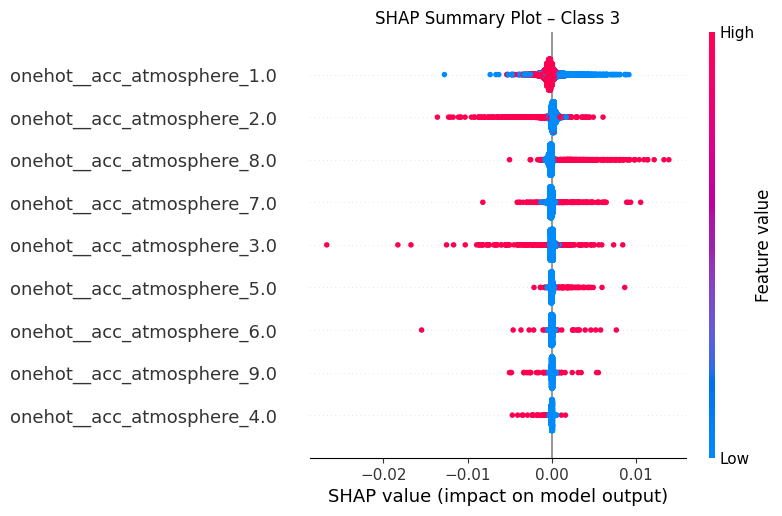

In [60]:
# feature 15:
subset_cols = [col for col in X_sub_df.columns if "acc_atmosphere" in col]

for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
candidates to aggregate: 1.0,4.0,5.0,6.0,9.0
keep the rest

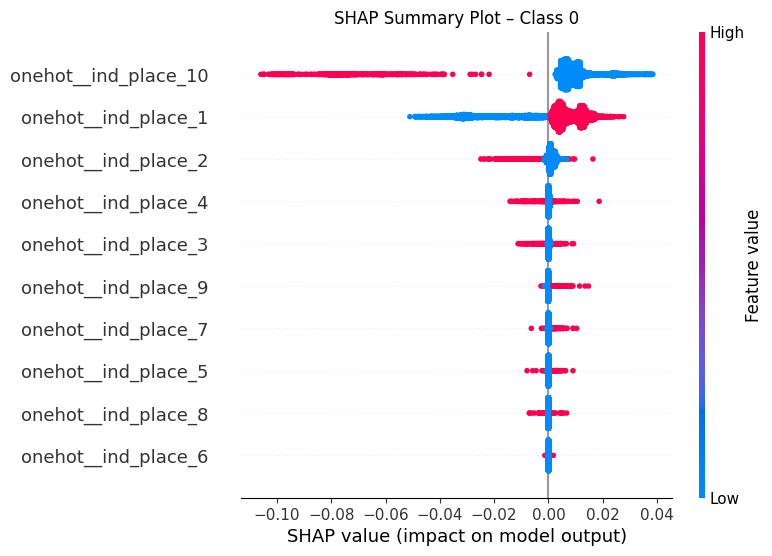

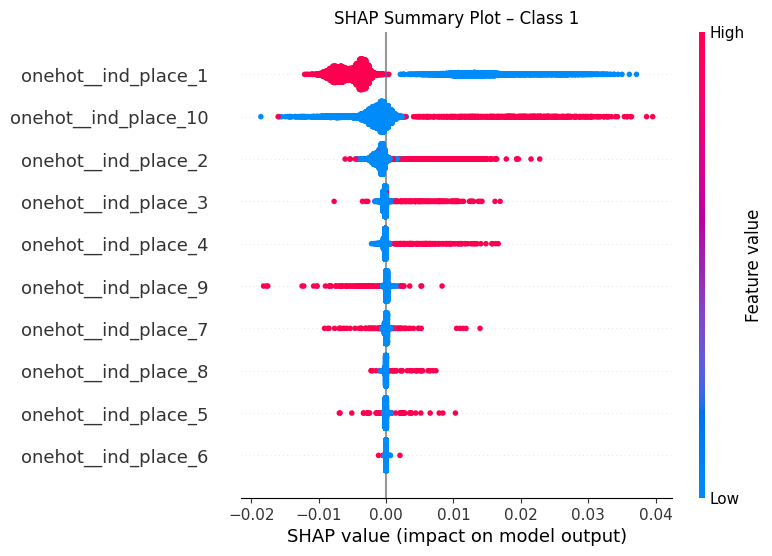

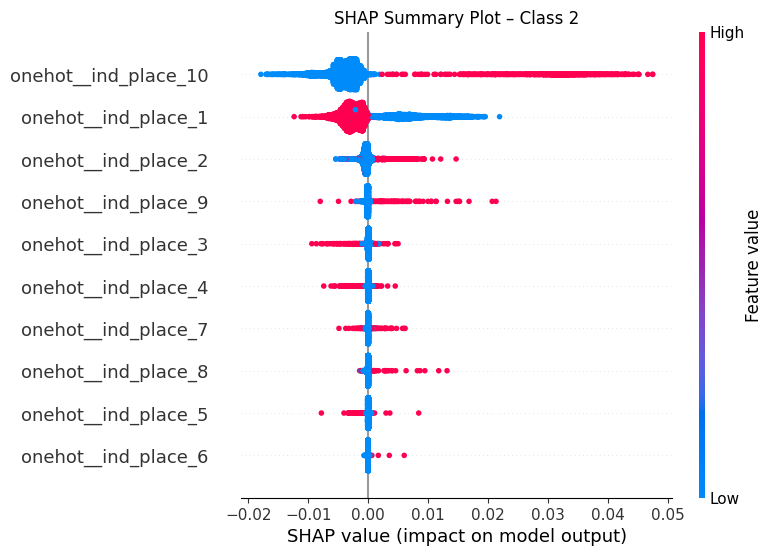

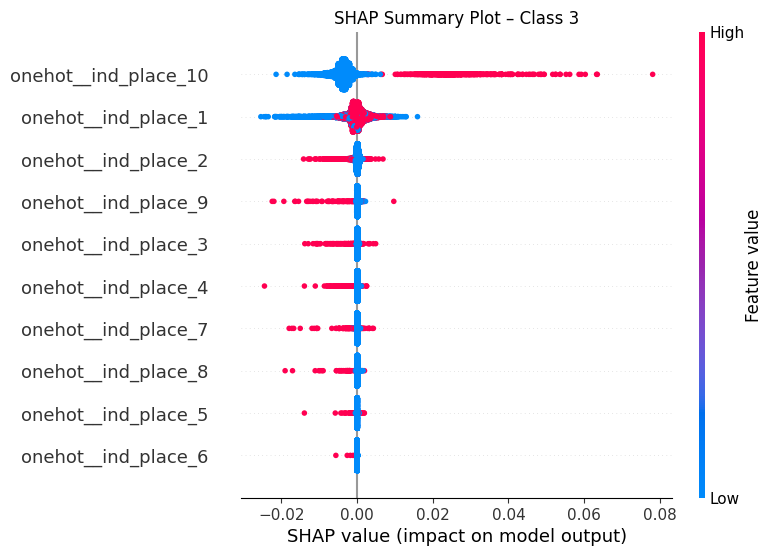

In [61]:
# feature 16:
subset_cols = [col for col in X_sub_df.columns if "ind_place" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
keep: 1,2,10 and try to aggregate the others

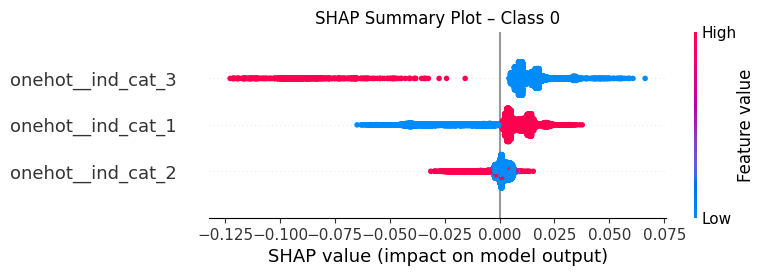

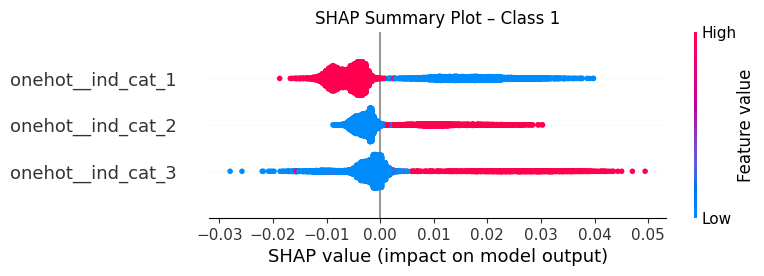

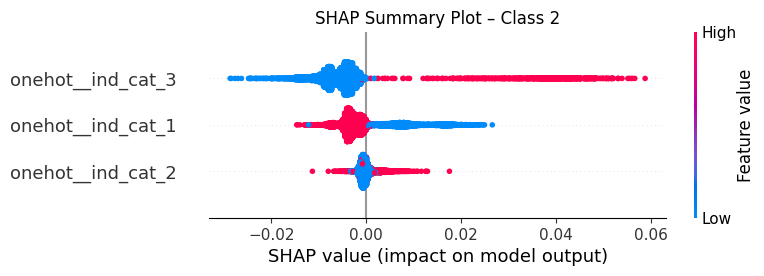

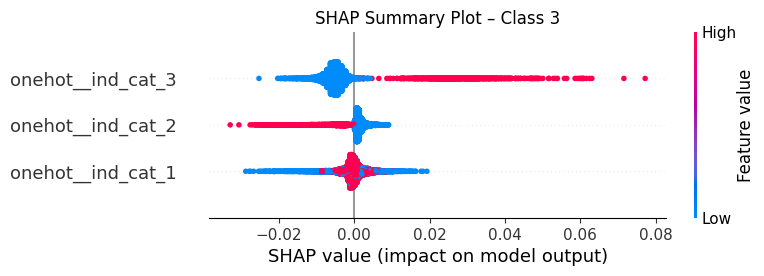

In [62]:
# feature 17:
subset_cols = [col for col in X_sub_df.columns if "ind_cat" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
keep all modalities


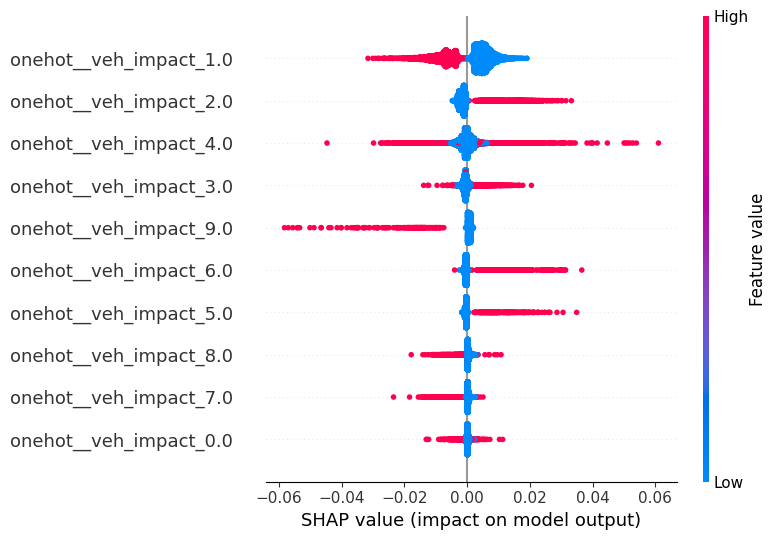

In [ ]:
# feature 18:
subset_cols = [col for col in X_sub_df.columns if "veh_impact" in col]
shap_class0 = shap_values.values[:, :, 0]  
shap.summary_plot(shap_class0[:, [X_sub_df.columns.get_loc(c) for c in subset_cols]],
                  X_sub_df[subset_cols],
                  feature_names=subset_cols)

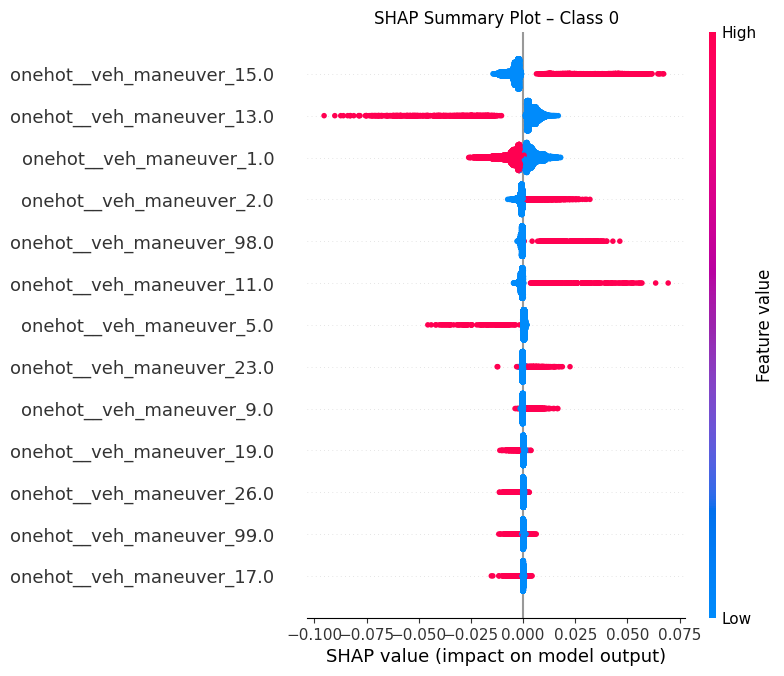

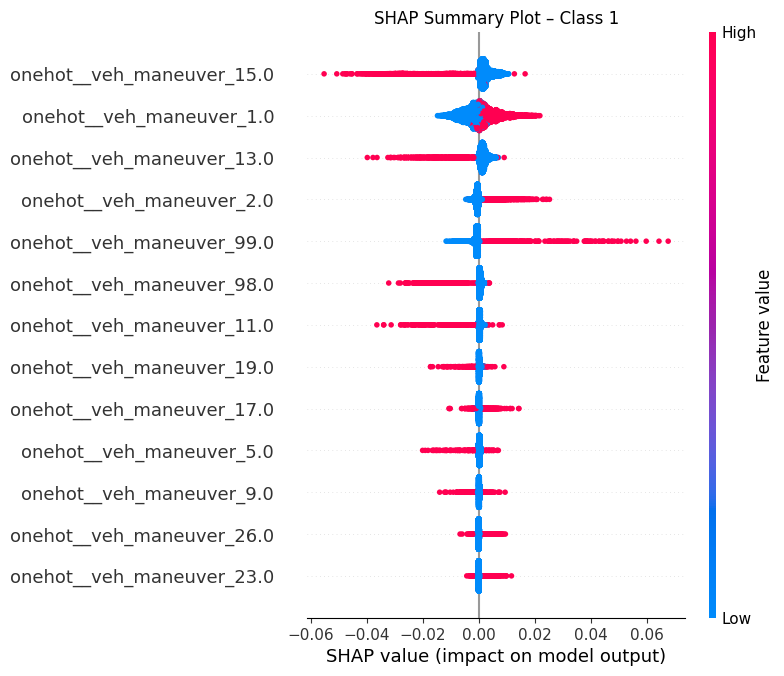

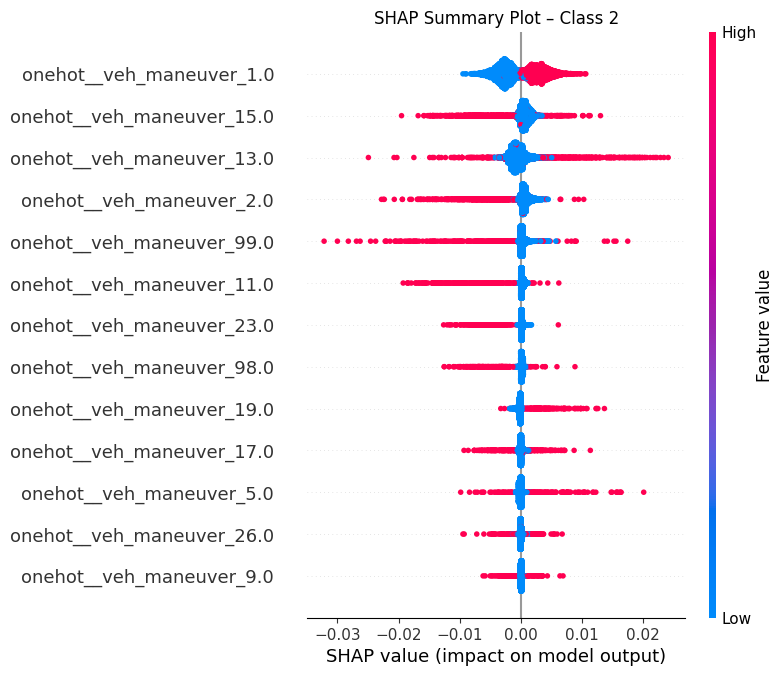

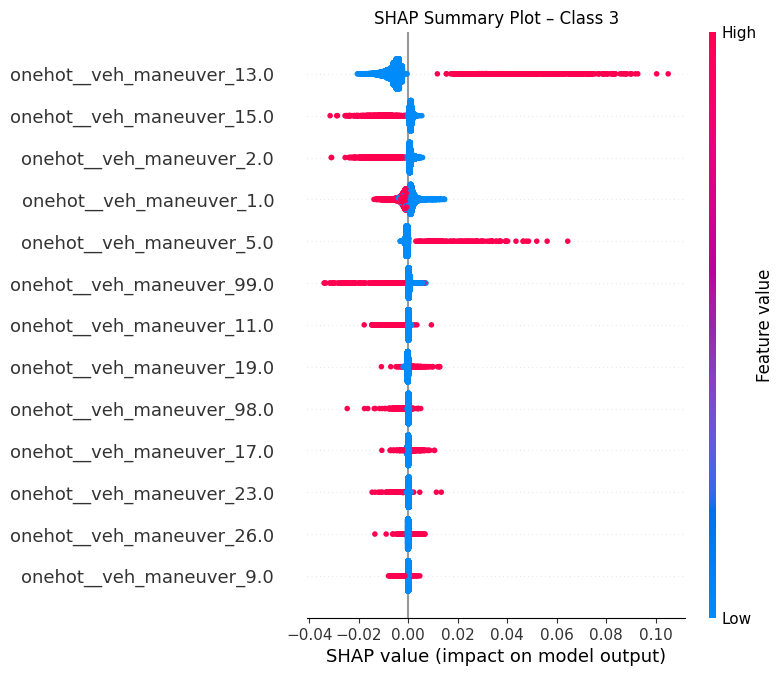

In [70]:
# feature 19:
subset_cols = [col for col in X_sub_df.columns if "veh_maneuver" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

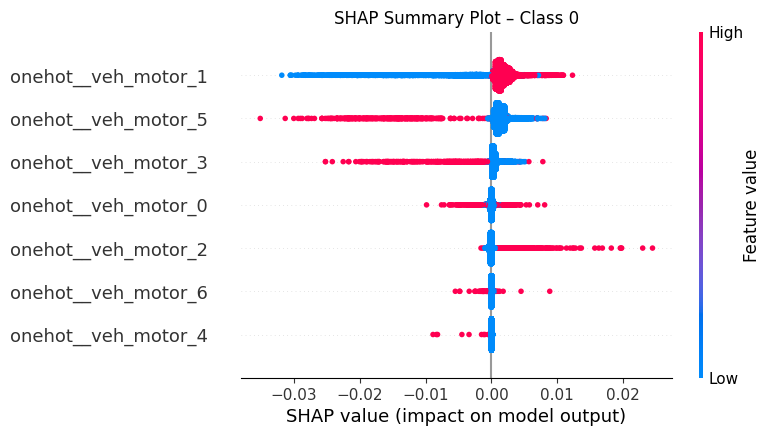

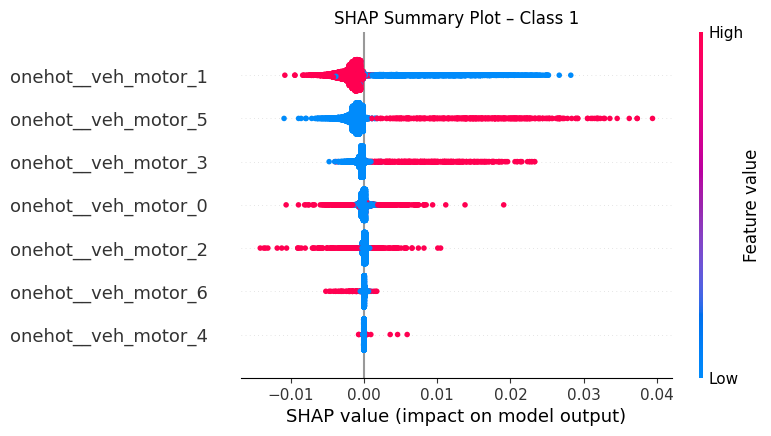

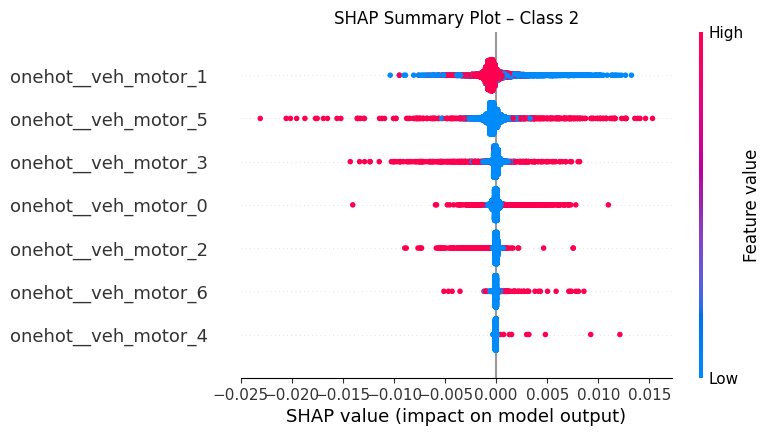

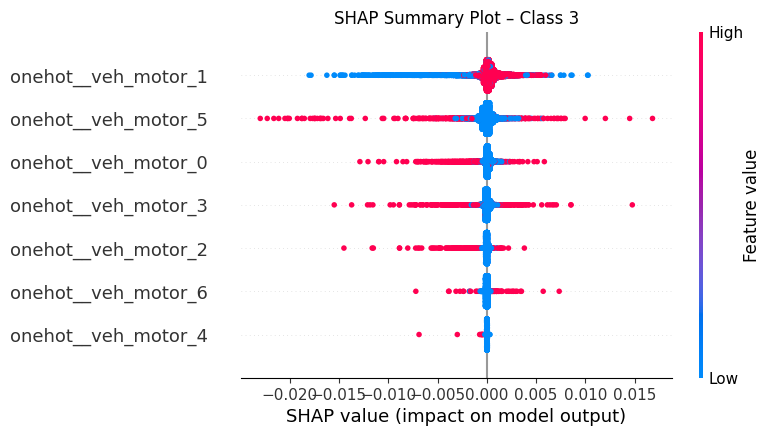

In [69]:
# feature 20:
subset_cols = [col for col in X_sub_df.columns if "veh_motor" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

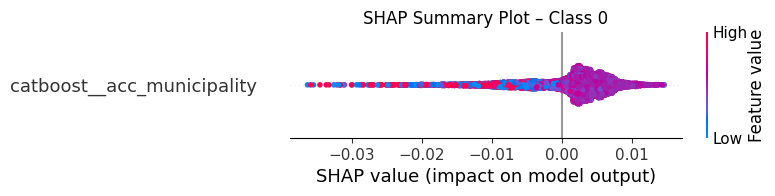

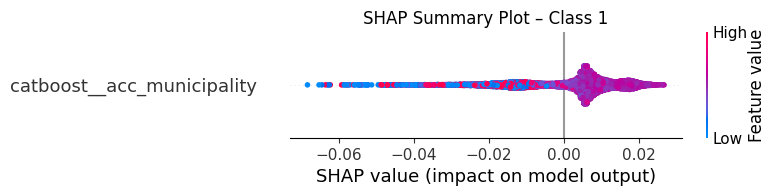

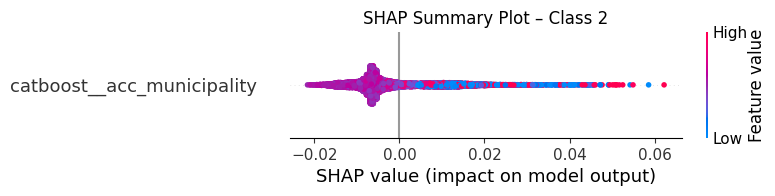

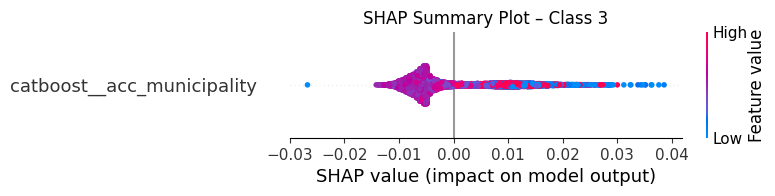

In [68]:
# feature 21:
subset_cols = [col for col in X_sub_df.columns if "acc_municipality" in col]
for c in range(4):
    shap_class = shap_values.values[:, :, c]
    shap.summary_plot(
        shap_class[:, [X_sub_df.columns.get_loc(col) for col in subset_cols]],
        X_sub_df[subset_cols],
        feature_names=subset_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – Class {c}")
    plt.show()

interpretation:
not sure how to interpret this feature. it shows many overlapping points. similiar pattern for 0, 1 and 2 ,3